# Estimate APA duration.

Analysis aiming to show that the interesting part of APAs lasts 60ms

To do this, we take the trace for the FR at each trial. 
We fit a 3-segment piece-wise linear curve to it.
We look at the middle segment (corresponding to when the mouse lifts the paw) and it's extent in time. 

In [64]:
import sys
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind as ttest
import pandas as pd
from sklearn.preprocessing import StandardScaler


import numpy as np
import os
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

# basepath = r"C:\Users\Federico\Documents\GitHub\APA_setup"
basepath = "/Users/federicoclaudi/Documents/github/APA_setup"
os.chdir(basepath)

sys.path.append("./")
sys.path.append(basepath)
sys.path.append(os.path.join(basepath, "analysis"))


from fcutils.plot.distributions import plot_kde
from fcutils.plot.figure import clean_axes
from analysis.process_data import DataProcessing
from analysis.fixtures import colors, sensors
from myterial import indigo, blue_grey_dark, salmon, cyan_dark

data = DataProcessing.reload()



[12/17/22 23:02:00] INFO     Starting data pre-processing with trials file:                     ]8;id=822132;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=169334;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#123\123]8;;\
                             /Volumes/EGZONA/Egzona/Forceplate/Analysis                                            
                             backup/100422_ALLtrials_CTRL-DTR_conditions.csv.                                      

                    INFO     Caliration file:                                                   ]8;id=696976;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=229594;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#126\126]8;;\
                             /Volumes/EGZONA/Egzona/Forceplate/forceplatesensors_calibration4.c                    
                             sv.                                                                                   

                    INFO     Found 36 subfolders                                                 ]8;id=571787;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=2445;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#57\57]8;;\

                    DEBUG    Setting previously stored params: {'DEBUG': True, 'CONDITIONS':     ]8;id=154690;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=965565;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#93\93]8;;\
                             ['WT', 'CTRL', 'DTR', 'CNO'], 'STRAINS': ['C57', 'VGLUT'],                            
                             'STANDING_STILL': False, 'calibrate': True, 'weight_percentage':                      
                             True, 'correct_for_paw': True, 'frames_file':                                         
                             '/Volumes/EGZONA/Egzona/Forceplate/Analysis                                           
                             backup/100422_ALLtrials_CTRL-DTR_conditions.csv',                                     
                             'calibration_file':                                                                   
                             '/Volumes/EGZONA/Egzona/Forceplate/forceplatesensors_calibration4.c                   
                             sv', 'main_fld': '/Volumes/EGZONA/Egzona/Forceplate/CURRENT                           
                             ANALYSIS TRIALS', 'fps': 600, 'smoothing_window': 0.01,                               
                             'on_sensor_weight_th': 2, 'on_all_sensors_weight_th': 66,                             
                             'n_secs_before': 0.2, 'n_secs_after': 0.2, 'min_baseline_duration':                   
                             0, 'trial_start_detection_window': 0.15, 'plot_individual_trials':                    
                             False}                                                                                

                    INFO     Starting data pre-processing with trials file:                     ]8;id=909265;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=304613;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#123\123]8;;\
                             /Volumes/EGZONA/Egzona/Forceplate/Analysis                                            
                             backup/100422_ALLtrials_CTRL-DTR_conditions.csv.                                      

                    INFO     Caliration file:                                                   ]8;id=485146;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=665326;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#126\126]8;;\
                             /Volumes/EGZONA/Egzona/Forceplate/forceplatesensors_calibration4.c                    
                             sv.                                                                                   

                    INFO     Loading previously saved data from:                                 ]8;id=72333;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=352758;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#98\98]8;;\
                             /Volumes/EGZONA/Egzona/Forceplate/CURRENT ANALYSIS TRIALS/data.h5                     

                    INFO     Loaded 91 trials -----                                             ]8;id=761373;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py\process_data.py]8;;\:]8;id=904488;file:///Users/federicoclaudi/Documents/github/APA_setup/analysis/process_data.py#105\105]8;;\
                                                                                                                   
                                                                                                                   

In [65]:
data.data.strain.unique()
data.data.condition.unique()

array(['WT', 'DTR'], dtype=object)

select trials by strain/condition

In [66]:
CONDITION = "CTRL"
STRAIN = "C57"

if STRAIN is not None:
    data = data.data.loc[(data.data.condition == CONDITION)&(data.data.strain == STRAIN)].reset_index()
else:
    data = data.data.loc[(data.data.condition == CONDITION)].reset_index()
    STRAIN = "any"
print(len(data))

data


0


,index,name,fr,fl,hr,hl,CoG,CoG_centered,condition,strain,tot_weight,on_sensors,movement_onset_frame,video,original_fps,paw


In [67]:
def get_traces(condition_trials:pd.DataFrame, t0=85, t1=140, subtractbl=True)->np.ndarray:
    """
        Get traces for all trials in a condition between the
        two reference frames. Returns an array of shape (4, n_frames, n_trials).
    """
    traces = np.zeros((4, t1 - t0, len(condition_trials)))

    for i, trial in condition_trials.iterrows():
        for n, paw in enumerate(sensors):
            bl = np.mean(trial[paw][0:85]) if subtractbl else 0
            traces[n, :, i] = trial[paw][t0:t1] -  bl  # remove baseline

    return traces



In [68]:

# frames ranges for cutting traces
trial_start_frame = 0
trial_end_frame = 239
APA_start_frame = 85

wt_traces_complete = get_traces(data, t0=trial_start_frame, t1=trial_end_frame, subtractbl=False)

time_frames = np.arange(trial_start_frame - 120, trial_end_frame - 120, 1)


In [69]:
from scipy import optimize


def ms2frame(ms):
    return int(ms / 1000 * 600)

def frame2ms(frame):
    return frame / 600 * 1000

def segments_fit(X, Y, count):
    """
        from https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
    """
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)


In [70]:
# set font size for labels in matplotlib
plt.rcParams.update({'font.size': 14})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


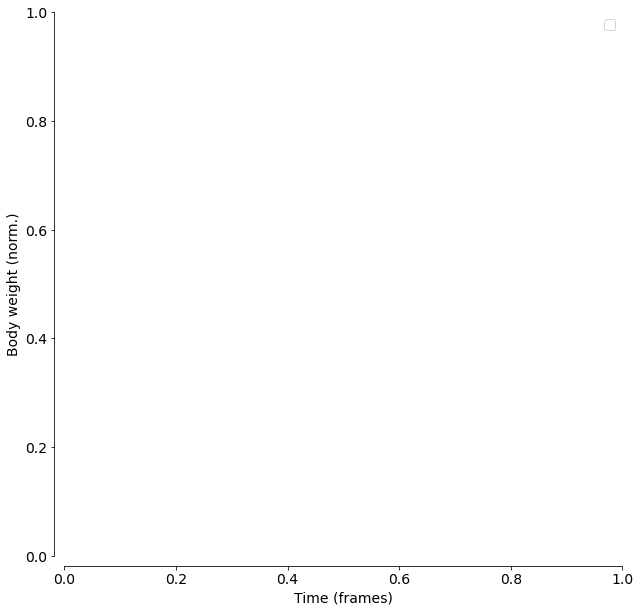

In [71]:
f, ax = plt.subplots(figsize=(10, 10),)


durations = []
for n, trial in enumerate(range(wt_traces_complete.shape[-1])):
    y = wt_traces_complete[1, :, trial]
    
    # scale y between 0, 1
    y = (y - y.min()) / (y.max() - y.min())
    

    # fit a piece-wise linear curve
    px, py = segments_fit(time_frames, y, 3)
    dur = px[2] - px[1]
    # if n == 0:
    if dur > 120:
        ax.plot(time_frames, y, color=[.3, .3, .3], lw=2, alpha=1, label="data")
        ax.plot(px, py, color=indigo, alpha=1, lw=6, label="fit")
        ax.scatter(px, py, s=250, lw=4, ec=indigo, fc="white", zorder=100)
    durations.append(dur)

    # break


from pathlib import Path
savepath = Path(r"/Volumes/EGZONA/Egzona/Thesis_Paper_Figures")

# save figure at savepath
ax.legend()
ax.set(xlabel="Time (frames)", ylabel="Body weight (norm.)")
clean_axes(f)
f.savefig(savepath / f"apa_duration_piecewisefit_example_condition_{CONDITION}_strain_{STRAIN}.svg", dpi=300)


### plot durations

IndexError: cannot do a non-empty take from an empty axes.

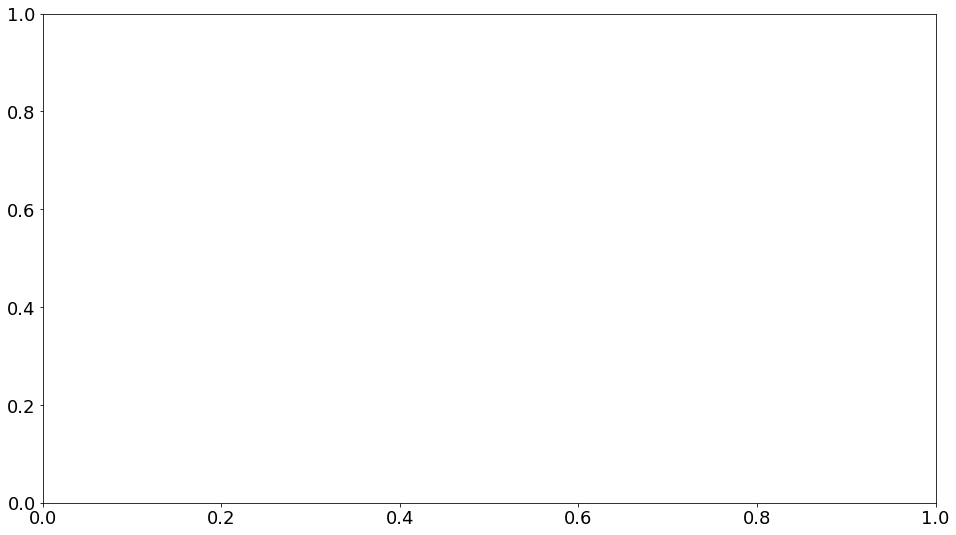

In [72]:
plt.rcParams.update({'font.size': 18})
f, ax = plt.subplots(figsize=(16, 9))

durations_ms = [frame2ms(d) for d in durations]

low, high = np.percentile(durations_ms, [5, 95])
print(f"low {low:.3f} ms high {high:.3f} ms, mean {np.mean(durations_ms):.3f} ms, median {np.median(durations_ms):.3f} ms, std: {np.std(durations_ms):.3f} ms | num {len(durations_ms)}")

ax.hist(durations_ms, bins=15, color=indigo)
ax.plot([low, high], [-.5, -.5], "-", color=indigo, lw=4)
ax.scatter(np.median(durations_ms), -.5, color="white", lw=4, ec=indigo, zorder=100,  s=150)

_ = ax.set(xlabel="duration (frames)", ylabel="count", title="APA duration")

clean_axes(f)
f.savefig(savepath / f"apa_duration_distribution_{CONDITION}_strain_{STRAIN}.svg", dpi=500)


### T tests

Manually run the analysis above for each condition and write down the values to be used in the ttest

In [ ]:
conditions_data = dict(
    condition = ["ctrl_c57", "dtr_c57", "dtr_vglut"],
    mean = [87.938, 80.362, 65.253],
    std = [61.430, 65.140, 50.862],
    median = [76.564, 65.637, 50.531],
    num = [61, 15, 15],
)

from scipy.stats import ttest_ind_from_stats
import statsmodels.stats.multitest as smm

_, ctrl_vs_dtrc57_pval = ttest_ind_from_stats(
        conditions_data["mean"][0],
        conditions_data["std"][0],
        conditions_data["num"][0],
        conditions_data["mean"][1],
        conditions_data["std"][1],
        conditions_data["num"][1]
        )


_, ctrl_vs_dtrvglut_pval = ttest_ind_from_stats(
        conditions_data["mean"][0],
        conditions_data["std"][0],
        conditions_data["num"][0],
        conditions_data["mean"][2],
        conditions_data["std"][2],
        conditions_data["num"][2]
        )

_, dtrc57_vs_dtrvglut = ttest_ind_from_stats(
        conditions_data["mean"][2],
        conditions_data["std"][2],
        conditions_data["num"][2],
        conditions_data["mean"][1],
        conditions_data["std"][1],
        conditions_data["num"][1]
        )


rejected, p_corrected, _, _ = smm.multipletests([ctrl_vs_dtrc57_pval, ctrl_vs_dtrvglut_pval, dtrc57_vs_dtrvglut], alpha=0.05, method='bonferroni')
print(f"""
    CTRL different from DTR c57? {rejected[0]} (p={p_corrected[0]:.5f})
    CTRL different from DTR vglut? {rejected[1]} (p={p_corrected[1]:.5f})
    DTR vglut different from DTR c57? {rejected[2]} (p={p_corrected[2]:.5f})
""")


    CTRL different from DTR c57? False (p=1.00000)
    CTRL different from DTR vglut? False (p=0.57148)
    DTR vglut different from DTR c57? False (p=1.00000)

